In [1]:
import numpy as np
import matplotlib.pyplot as plt
import struct, os

In [2]:
from utils.extract_utils import *
from utils.latticeeasy import *
from utils.gradient_utils import gradient_discrete
from utils.label_utils import get_labels, label_blobs

In [3]:
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 9})
rc('text', usetex=True)
rc('image', cmap='gist_heat_r')
rc('axes', **{'titlesize': 9})

plt.rcParams['axes.axisbelow'] = True

from mpl_toolkits.axes_grid1 import make_axes_locatable

# Load data

In [4]:
output_dir = "/media/yangelaxue/23E7CCB1624D2A50/Colliding_Oscillons/alpha_beta-0.25_80_351.512634/trial_2/osc17_128"
output_pardir = "/media/yangelaxue/23E7CCB1624D2A50/Colliding_Oscillons/alpha_beta-0.25_80"
data = LATTICEEASY(output_dir)
data.__dict__

{'output_dir': '/media/yangelaxue/23E7CCB1624D2A50/Colliding_Oscillons/alpha_beta-0.25_80_351.512634/trial_2/osc17_128',
 'alpha': 0.25,
 'beta': 80.0,
 'phi_0': 0.080613,
 'dt_pr': 0.001,
 'dim': 3,
 'domain_width_pr': array([0.230482, 0.230482, 0.230482]),
 'domain_dimensions': (128, 128, 128),
 't': array([ 0.999991,  2.000037,  3.999892,  5.999747,  7.999603,  9.000008,
        10.000412, 11.000816, 12.001221, 13.001625, 14.002029, 15.002434,
        16.002834, 18.001736, 20.000637, 21.999538, 23.99844 , 25.997341,
        27.996243, 29.995144, 31.994045, 33.992947, 35.991848, 37.990749,
        39.989651, 41.988552, 43.987453, 45.986355, 47.985256, 49.984158,
        51.983059, 53.98196 , 55.980862, 57.979763, 59.978664, 61.977566,
        63.976467, 65.975365, 67.974266, 69.973167, 71.972069, 73.97097 ,
        75.969872, 77.968773, 79.967674, 81.966576, 83.965477, 85.964378,
        87.96328 , 89.962181, 91.961082, 93.959984, 95.958885, 97.957787,
        99.956688, 99.999664]),

In [5]:
timeslice = 0

a, ap = data.a[timeslice], data.ap[timeslice]

# dt_pr = data.dt_pr
# domain_width_pr = data.domain_width_pr
# domain_dimensions = data.domain_dimensions
# domain_width_pr, domain_dimensions

In [6]:
n_points = np.product(data.domain_dimensions)

grid_file = "osc17.img"
with open(os.path.join(output_dir,grid_file),'rb') as grid:
    
    grid_content = grid.read()
    
    phi = struct.unpack("f" * n_points, grid_content[16:16+4*n_points])
    phip = struct.unpack("f" * n_points, grid_content[16+4*n_points:])
    
phi = np.array(phi).reshape(data.domain_dimensions)
phip = np.array(phip).reshape(data.domain_dimensions)

phi = phi - data.dt_pr/2 * phip

In [7]:
Edens = get_Edens_pr(
    phi, phip, a, ap, data.alpha, data.beta, data.phi_0, dxdydz_pr=data.domain_width_pr/data.domain_dimensions
    )

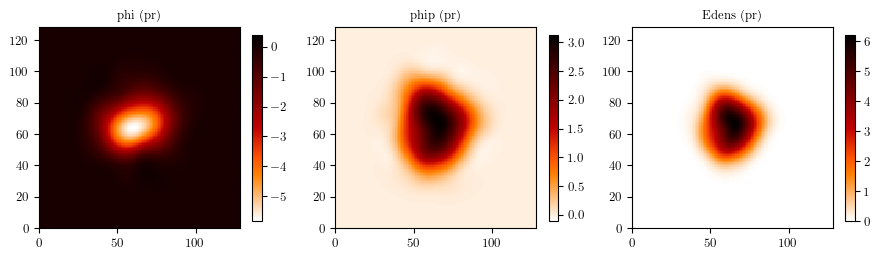

In [8]:
cross = 64

fig, axes = plt.subplots(1,3,figsize=(9,4),tight_layout=True)

for ax in axes:
    ax.set_aspect('equal')

mesh = axes[0].pcolormesh(phi[:,cross],
              vmin=phi.min(), vmax=phi.max(),
              )
axes[0].set_title("phi (pr)")
fig.colorbar(mesh,shrink=.5)

mesh = axes[1].pcolormesh(phip[:,cross],
              vmin=phip.min(), vmax=phip.max(),
              )
axes[1].set_title("phip (pr)")
fig.colorbar(mesh,shrink=.5)

mesh = axes[2].pcolormesh(Edens[:,cross],
              vmin=Edens.min(), vmax=Edens.max(),
              )
axes[2].set_title("Edens (pr)")
fig.colorbar(mesh,shrink=.5)

plt.show()

# Add oscillon to background

In [9]:
def add_field_to_bg(bg, *vals):
    
    shape = vals[0].shape
    for val in vals:
        assert val.shape==shape, "All fields must be of the same shape"
        
    shape_bg = bg.shape
    
    centre = [shp_bg//2 for shp_bg in shape_bg]
    idxes = tuple([slice(centre[i]-shape[i]//2,centre[i]+shape[i]//2) for i in range(len(shape))])
    
    vals_bg = []
    for val in vals:
        val_bg = bg.copy()
        val_bg[idxes] = val
        vals_bg.append(val_bg)
        
    return vals_bg

In [10]:
pad = 64
shape_bg = tuple(dim_x+2*pad for dim_x in data.domain_dimensions)

if pad==0:
    phi_bg, phip_bg, Edens_bg = phi, phip, Edens
    print("skip background")
else:
    phi_bg, phip_bg = add_field_to_bg(np.zeros(shape_bg), phi, phip)
    Edens_bg = get_Edens_pr(
        phi_bg, phip_bg, a, ap, data.alpha, data.beta, data.phi_0, dxdydz_pr=data.domain_width_pr/data.domain_dimensions
    )

In [11]:
domain_width_pr = data.domain_width_pr*shape_bg/data.domain_dimensions
data.domain_width_pr, domain_width_pr

(array([0.230482, 0.230482, 0.230482]), array([0.460964, 0.460964, 0.460964]))

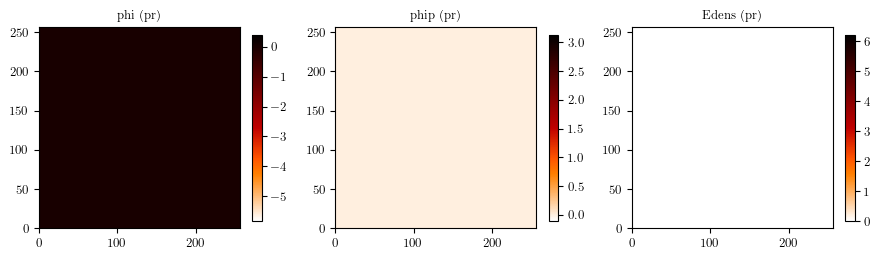

In [12]:
cross = 64

fig, axes = plt.subplots(1,3,figsize=(9,4),tight_layout=True)

for ax in axes:
    ax.set_aspect('equal')

mesh = axes[0].pcolormesh(phi_bg[:,cross],
              vmin=phi.min(), vmax=phi.max(),
              )
axes[0].set_title("phi (pr)")
fig.colorbar(mesh,shrink=.5)

mesh = axes[1].pcolormesh(phip_bg[:,cross],
              vmin=phip.min(), vmax=phip.max(),
              )
axes[1].set_title("phip (pr)")
fig.colorbar(mesh,shrink=.5)

mesh = axes[2].pcolormesh(Edens_bg[:,cross],
              vmin=Edens.min(), vmax=Edens.max(),
              )
axes[2].set_title("Edens (pr)")
fig.colorbar(mesh,shrink=.5)

plt.show()

# Interpolate

In [13]:
# shape_i = (128,128,128)
shape_i = (256,256,256)
# shape_i = data.domain_dimensions

if shape_i==shape_bg:
    print("skip interpolate")
    phi_i, phip_i, Edens_i = phi_bg, phip_bg, Edens_bg
else:
    phi_i, phip_i, Edens_i = interpolate(shape_i, phi_bg, phip_bg, Edens_bg)
    
print(phi_i.shape)

skip interpolate
(256, 256, 256)


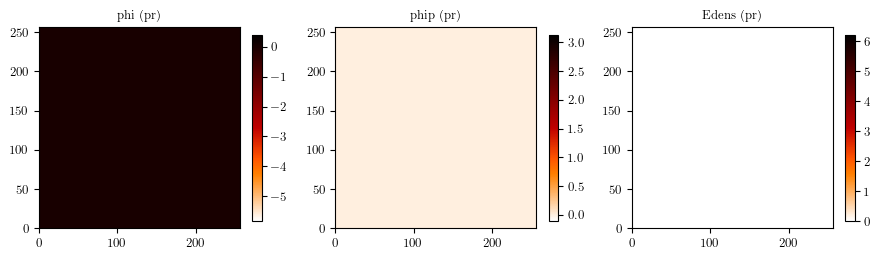

In [14]:
cross = 64

fig, axes = plt.subplots(1,3,figsize=(9,4),tight_layout=True)

for ax in axes:
    ax.set_aspect('equal')

mesh = axes[0].pcolormesh(phi_i[:,cross],
              vmin=phi.min(), vmax=phi.max(),
              )
axes[0].set_title("phi (pr)")
fig.colorbar(mesh,shrink=.5)

mesh = axes[1].pcolormesh(phip_i[:,cross],
              vmin=phip.min(), vmax=phip.max(),
              )
axes[1].set_title("phip (pr)")
fig.colorbar(mesh,shrink=.5)

mesh = axes[2].pcolormesh(Edens_i[:,cross],
              vmin=Edens.min(), vmax=Edens.max(),
              )
axes[2].set_title("Edens (pr)")
fig.colorbar(mesh,shrink=.5)

plt.show()

## Shift oscillon to center

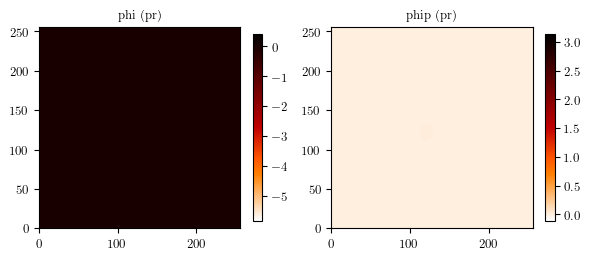

In [15]:
if 1:
    center = tuple(np.round(np.array([(Edens_i*x).sum() for x in np.indices(shape_i)])/Edens_i.sum()).astype(int))

    phi_sh, phip_sh, Edens_sh = shift_volume(center, phi_i, phip_i, Edens_i)
    
    cross = 80

    fig, axes = plt.subplots(1,2,figsize=(6,4),tight_layout=True)

    for ax in axes:
        ax.set_aspect('equal')

    mesh = axes[0].pcolormesh(phi_sh[:,cross],
                  vmin=phi_i.min(), vmax=phi_i.max(),
                  )
    axes[0].set_title("phi (pr)")
    fig.colorbar(mesh,shrink=.5)

    mesh = axes[1].pcolormesh(phip_sh[:,cross],
                  vmin=phip_i.min(), vmax=phip_i.max(),
                  )
    axes[1].set_title("phip (pr)")
    fig.colorbar(mesh,shrink=.5)
else:
    phi_sh, phip_sh, Edens_sh = phi_i, phip_i, Edens_i

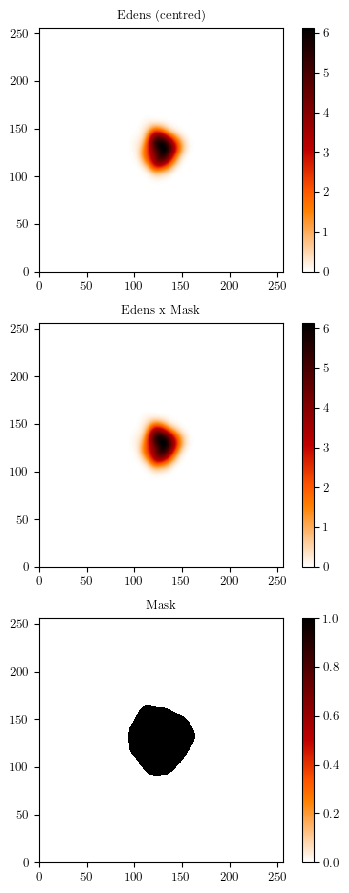

In [16]:
Edens_mean = load_energy(output_pardir, 4)[1:].sum()
mask_trial = Edens_sh>Edens_mean/2**4
cross = shape_i[0]//2

fig, axes = plt.subplots(3,1,figsize=(4,9),tight_layout=True)

for ax in axes:
    ax.set_aspect('equal')

mesh = axes[0].pcolormesh(Edens_sh[:,cross],
              )
axes[0].set_title("Edens (centred)")
fig.colorbar(mesh)

mesh = axes[1].pcolormesh((Edens_sh*mask_trial)[:,cross],
              )
axes[1].set_title("Edens x Mask")
fig.colorbar(mesh,)

mesh = axes[2].pcolormesh(mask_trial[:,cross],
              )
axes[2].set_title("Mask")
fig.colorbar(mesh,)

plt.show()

# Boost

In [17]:
c_pr = 1/a**(data.rescale_s+1) # Speed limit in code units
c_pr

0.0037783440049333774

In [18]:
def boost_oscillon(boost, phi, phip, domain_width):
    
    assert phi.shape==phip.shape
    shape = phi.shape
    
    grad = gradient_discrete(phi, domain_width/shape, stencil=5)
    
#     plt.pcolormesh(grad[0][64])
#     plt.colorbar()
#     plt.show()
    
#     grad_test = (phi[1:]-phi[:-1])/(domain_width/shape)[0]
#     print(grad_test.shape)
    
#     plt.pcolormesh(grad_test[64])
#     plt.colorbar()
#     plt.show()
    
#     plt.pcolormesh(phi[128])
#     plt.colorbar()
#     plt.show()
    
    phip_boost = phip - np.sum([boost_x*grad_x for boost_x,grad_x in zip(boost,grad)],axis=0)
    
    # Print momentum and speed
    Edens_boost = get_Edens_pr(
    phi, phip_boost, a, ap, data.alpha, data.beta, data.phi_0, dxdydz_pr=domain_width_pr/shape
    )
    momenta_pr_boost = get_momenta_pr(phi, phip_boost, a, ap, data.alpha, data.beta, data.phi_0, domain_width_pr/shape)
    field_speed_boost = get_field_speed_pr(momenta_pr_boost, Edens_boost, a, data.alpha)
    print(f"field speed = {field_speed_boost/c_pr} c_pr")
    print(f"momenta = {momenta_pr_boost.sum(axis=(1,2,3))}")
    
    return phip_boost, field_speed_boost

In [19]:
# """
# View momentum before applying boost.
# """

# mask = mask_trial
# phi_sh_boost = boost_oscillon([0,0,0], phi_sh*mask, phip_sh*mask, domain_width_pr)

# mask = np.ones(shape_i)
phip_sh_boost = boost_oscillon([0,0,0], phi_sh, phip_sh, domain_width_pr)

field speed = [ 0.00290651  0.00362294 -0.01768184] c_pr
momenta = [ 104618.7584382   130406.21151707 -636451.21915371]


In [20]:
boost = np.array([0.4043, -0.06404, 0.5876]) * c_pr

phip_sh_boost, field_speed_boost_pr = boost_oscillon(boost, phi_sh, phip_sh, domain_width_pr)

field speed = [1.99991863e-02 5.39663124e-06 9.18945132e-06] c_pr
momenta = [7.19373096e+05 1.94117464e+02 3.30545650e+02]


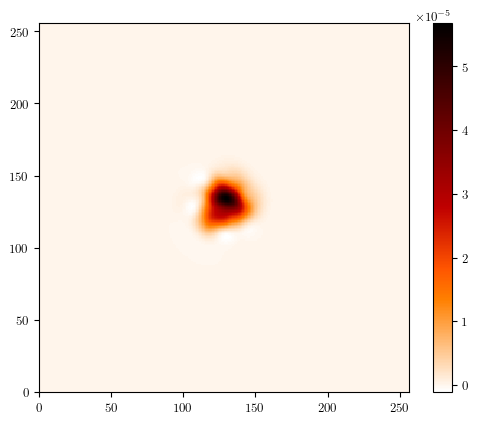

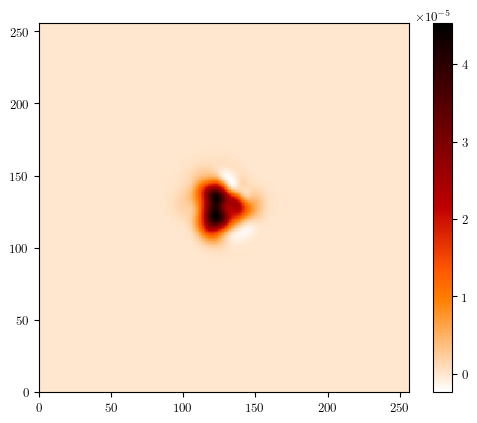

In [21]:
plt.pcolormesh(phip_sh[64])
plt.gca().set_aspect('equal')
plt.colorbar()
plt.show()

plt.pcolormesh(phip_sh_boost[64])
plt.gca().set_aspect('equal')
plt.colorbar()
plt.show()

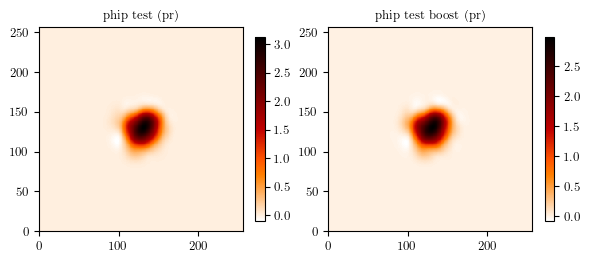

In [22]:
cross = shape_i[0]//2

fig, axes = plt.subplots(1,2,figsize=(6,2.9),tight_layout=True)

im = axes[0].pcolormesh(phip_sh[cross])
axes[0].set_title("phip test (pr)")
fig.colorbar(im,shrink=.7)

im = axes[1].pcolormesh(phip_sh_boost[cross])
axes[1].set_title("phip test boost (pr)")
fig.colorbar(im,shrink=.7)

for ax in axes:
    ax.set_aspect('equal')

plt.show()

# fig, axes = plt.subplots(1,2,figsize=(6,2.9),tight_layout=True)

# im = axes[0].pcolormesh(Edens_sh[cross])
# axes[0].set_title("Edens (pr)")
# fig.colorbar(im,shrink=.7)

# im = axes[1].pcolormesh(Edens_boost[cross])
# axes[1].set_title("Edens boost (pr)")
# fig.colorbar(im,shrink=.7)

# for ax in axes:
#     ax.set_aspect('equal')

# plt.show()

# Interpolate (again)

In [23]:
# shape_i_2 = (128,128,128)
shape_i_2 = (256,256,256)
# shape_i = data.domain_dimensions

if shape_i_2==shape_i:
    print("skip interpolate")
    phi_2, phip_2 = phi_sh, phip_sh_boost
else:
    phi_2, phip_2 = interpolate(shape_i_2, phi_sh, phip_sh_boost)
    Edens_2 = get_Edens_pr(
        phi_2, phip_2, a, ap, data.alpha, data.beta, data.phi_0, dxdydz_pr=domain_width_pr/shape_i_2
    )
    
    momenta_2 = get_momenta_pr(phi_2, phip_2, a, ap, data.alpha, data.beta, data.phi_0, domain_width_pr/shape_i_2)
    field_speed_2 = get_field_speed_pr(momenta_2, Edens_2, a, data.alpha)
    print(field_speed_2/c_pr)
    print(momenta_2.sum(axis=(1,2,3)))

skip interpolate


# Save data as grid.img

In [24]:
dt_pr = data.dt_pr
# dt_pr = 0.001

print(dt_pr)

phi_2_adv = phi_2 + dt_pr/2*phip_2

0.001


In [25]:
shape_i_2, domain_width_pr, dt_pr, data.phi_0, dt_pr/(domain_width_pr/shape_i_2)

((256, 256, 256),
 array([0.460964, 0.460964, 0.460964]),
 0.001,
 0.080613,
 array([0.5553579, 0.5553579, 0.5553579]))

In [26]:
n_points = np.product(shape_i_2)

fname_o = f"boost.img"
datname_o = f"boost.dat"
fdir = f"boost_0.02c_{shape_i_2[0]}"
# fname_o = f"highres_boost.img"
# datname_o = f"highres_boost.dat"
# fdir = f"highres_boost"
# fname_o = f"stationary.img"
# datname_o = f"stationary.dat"
# fdir = f"stationary_{shape_i[0]}"

# fname_o = f"cont.img"
# datname_o = f"cont.dat"
# fdir = f"./"
# fname_o = f"{fname}_noboost.img"
# datname_o = f"{fname}_noboost.dat"

if not os.path.exists(os.path.join(output_dir, fdir)):
    os.makedirs(os.path.join(output_dir, fdir))

with open(os.path.join(output_dir, fdir, datname_o), 'w') as dat:
    dat.write(f"N = {phi_2_adv.shape}\n")
    dat.write(f"L_pr = {domain_width_pr}\n")
    dat.write(f"dt_pr = {dt_pr}\n")
    dat.write(f"f0 = {data.phi_0}\n")
    dat.write(f"alpha = {data.alpha}\n")
    dat.write(f"beta = {data.beta}\n")
    dat.write(f"f0 = {data.phi_0}\n")
    dat.write(f"\n")
    
    dat.write(f"Boost given in x, y, z direction in code units is\n")
    dat.write(f"{boost/c_pr} x c_pr = {boost}\n")
    dat.write("Final average speed compared to c is\n")
    dat.write(f"{field_speed_boost_pr/c_pr} x c_pr = {field_speed_boost_pr} \n")
    
#     dat.write("\n")
#     dat.write("This was boosted first and then interpolated.\n")
    
#     if "boost" in fdir:
#         dat.write(f"Or .01c_pr in the x direction.\n")
    
#     if fdir=="highres_boost":
#         dat.write("\n")
#         dat.write(f"High resolution timesteps begins at t={data.t[timeslice]}\n")
    
    dat.write("\n")
    dat.write(f"{output_dir = }")

with open(os.path.join(output_dir, fdir, fname_o),'wb') as f_o:
    
    f_o.write(struct.pack('<i',-1))
#     f_o.write(struct.pack('<f',data.t[timeslice]))
    f_o.write(struct.pack('<f',0))
    f_o.write(struct.pack('<f',data.a[timeslice]))
    f_o.write(struct.pack('<f',data.ap[timeslice]))
    
    f_o.write(struct.pack('<'+'f'*n_points,*phi_2_adv.flatten()))
    f_o.write(struct.pack('<'+'f'*n_points,*phip_2.flatten()))